In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import urllib
import tensorflow_datasets as tfds

In [3]:
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [5]:
if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

train_images = np.load(f'npy_files/{category}.npy')
print(f'{len(train_images)} images to train on')

141545 images to train on


In [11]:
print(np.min(train_images), np.max(train_images))

0 255


In [20]:
dataset = tf.data.Dataset.from_tensor_slices(train_images)

def preprocess(data):
    # DATA TYPE
    data = data.map(lambda img: (tf.cast(img, tf.float32)))
    # NORMALIZE
    data = data.map(lambda img: (img/255.))
    # DUPING AND NOISE
    data = data.map(lambda img: (tf.reshape(img, (28, 28, 1))))
    # DATAFLOW PREP
    data = data.cache()
    data = data.shuffle(1000, seed=42)
    data = data.batch(32)
    data = data.prefetch(3)
    return data

dataset = dataset.apply(preprocess)

2023-01-23 17:58:42.226783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


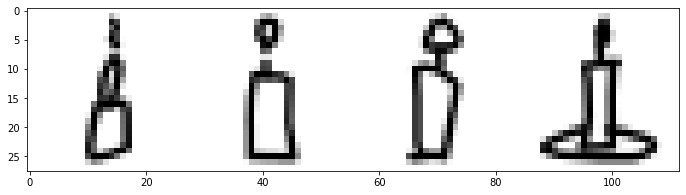

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

x = next(iter(dataset))

x = tf.concat([x[i, ...] for i in range(4)], axis=1)
plt.figure(figsize=(12, 3))
plt.imshow(x, cmap='binary')
plt.show()

In [29]:
import datetime
from tqdm import tqdm



class Model(tf.keras.Model):
    NAME = 'NAMELESS_MODEL'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.is_setup = False
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.prev_epochs = 0
    
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    
    def setup(self):
        if self.is_setup:
            return
        # DEFINE PATHSf
        current_time = datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
        train_log_path = f"logs/{self.NAME}{current_time}/train"
        val_log_path = f"logs/{self.NAME}{current_time}/val"
        # CONSTRUCT WRITERS
        self.writer_train = tf.summary.create_file_writer(train_log_path)
        self.writer_val   = tf.summary.create_file_writer(val_log_path)
        self.is_setup = True
    
    
    @tf.function
    def call(self, x, training=False):
        for layer in self.layers:
            x = layer(x, training=training)
        return x
    
    
    @tf.function
    def step(self, X, training=True):
        if training:
            with tf.GradientTape() as tape:
                L = self.loss(X)
            gradient = tape.gradient(L, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradient, self.trainable_weights))
        else:
            L = self.loss(X)
        self.loss_metric.update_state(L)
        return {metric.name: float(metric.result()) for metric in self.metrics}


    def train(self, train, epochs):
        training_metrics = {metric.name: [] for metric in self.metrics}
        testing_metrics = {metric.name: [] for metric in self.metrics}
        self.setup()
        with tqdm(epochs) as bar:
            bar.set_description('TRAINING')
            for epoch in range(epochs):
                # TRAINING
                for X in train:
                    metrics = self.step(X, training=True)
                    for name, value in metrics.items():
                        training_metrics[name].append(value)
                # WRITING METRICS
                with self.writer_train.as_default():
                    for metric in self.metrics:
                        tf.summary.scalar(metric.name, metric.result(), step=self.prev_epochs)
                self.reset_metrics()
                bar.update(1)
                self.prev_epochs += 1
            metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in self.metrics}
            return metrics

In [41]:
class Generator(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(9 * 256, activation='relu')
        self.flatten = tf.keras.layers.Reshape((3, 3, 256))
        self.conv_0 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu')
        # (7, 7, 256)
        self.conv_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')
        self.norm_0 = tf.keras.layers.BatchNormalization()
        self.conv_3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')
        # (14, 14, 128)
        self.conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv_5 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')
        self.norm_1 = tf.keras.layers.BatchNormalization()
        self.conv_6 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')
        # (28, 28, 128)
        self.conv_7 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.conv_8 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.norm_2 = tf.keras.layers.BatchNormalization()
        self.conv_9 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        
    def call(self, batch_size, training=True):
        X = tf.random.normal((batch_size, 256))
        X = self.dense(X, training=training)
        X = self.flatten(X, training=training)
        X = self.conv_0(X, training=training)
        # 1st BLOCK
        Z = self.conv_1(X, training=training)
        Z = self.conv_2(Z, training=training)
        Z = Z + X
        self.norm_0(Z, training=training)
        X = self.conv_3(Z, training=training)
        # 2nd BLOCK
        Z = self.conv_4(X, training=training)
        Z = self.conv_5(Z, training=training)
        Z = Z + X
        self.norm_1(Z, training=training)
        X = self.conv_6(Z, training=training)
        # 3rd BLOCK
        Z = self.conv_7(X, training=training)
        Z = self.conv_8(Z, training=training)
        Z = Z + X
        self.norm_2(Z, training=training)
        X = self.conv_9(Z, training=training)
        return X
        


class Discriminator(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_0 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        # (28, 28, 64)
        self.conv_1 = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.conv_2 = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.norm_0 = tf.keras.layers.BatchNormalization()
        self.pool_0 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))
        # (14, 14, 128)
        self.conv_3 = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.conv_4 = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.norm_1 = tf.keras.layers.BatchNormalization()
        self.pool_1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))
        # (7, 7, 256)
        self.conv_5 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.conv_6 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.norm_2 = tf.keras.layers.BatchNormalization()
        self.pool_2 = tf.keras.layers.GlobalAveragePooling2D()
        # (256)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    
    def call(self, X, training=True):
        # Constructing Filterspace
        X = self.conv_0(X, training=training)
        # 1st BLOCK
        Z = self.conv_1(X, training=training)
        Z = self.conv_2(Z, training=training)
        Z = Z + tf.concat([X, X], axis=3)
        Z = self.norm_0(Z, training=training)
        X = self.pool_0(Z, training=training)
        # 2nd BLOCK
        Z = self.conv_3(X, training=training)
        Z = self.conv_4(Z, training=training)
        Z = Z + tf.concat([X, X], axis=3)
        Z = self.norm_1(Z, training=training)
        X = self.pool_1(Z, training=training)
        # 3rd BLOCK
        Z = self.conv_5(X, training=training)
        Z = self.conv_6(Z, training=training)
        Z = Z + tf.concat([X, X], axis=3)
        Z = self.norm_2(Z, training=training)
        X = self.pool_2(Z, training=training)
        # FINALLY
        X = self.flatten(X)
        P = self.dense(X)
        return P



G = Generator()
D = Discriminator()
D(G(2))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.52494144],
       [0.4750586 ]], dtype=float32)>

In [54]:
import datetime
from tqdm import tqdm



class GAN(tf.keras.Model): # aka Adversarial Minmax
    NAME = 'NAMELESS_MODEL'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.G = Generator()
        self.D = Discriminator()
        self.is_setup = False
        self.loss = tf.keras.losses.BinaryCrossentropy()
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.prev_epochs = 0
    
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    
    def setup(self):
        if self.is_setup:
            return
        # DEFINE PATHSf
        current_time = datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
        train_log_path = f"logs/{self.NAME}{current_time}"
        # CONSTRUCT WRITERS
        self.writer = tf.summary.create_file_writer(train_log_path)
        self.is_setup = True
    
    
    @tf.function
    def call(self, X_true, training=False):
        batch_size = X_true.shape[0]
        X_false = self.G(batch_size)
        X = tf.concat([X_true, X_false], axis=0)
        P = self.D(X)
        return P
    
    
    @tf.function
    def step(self, X_true, training=True):
        batch_size = X_true.shape[0]
        T = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        if training:
            with tf.GradientTape(persistent=True) as tape:
                P = self(X_true, training=training)
                L_D = self.loss(T, P)
                L_G = -L_D
            nabla_G = tape.gradient(L_G, self.G.trainable_weights)
            nabla_D = tape.gradient(L_D, self.D.trainable_weights)
            self.G.optimizer.apply_gradients(zip(nabla_G, self.G.trainable_weights))
            self.D.optimizer.apply_gradients(zip(nabla_D, self.D.trainable_weights))
        else:
            P = self(X_true)
            L_D = self.loss(T, P)
        self.loss_metric.update_state(L_D)
        return {metric.name: float(metric.result()) for metric in self.metrics}


    def train(self, dataset, epochs):
        training_metrics = {metric.name: [] for metric in self.metrics}
        testing_metrics = {metric.name: [] for metric in self.metrics}
        self.setup()
        with tqdm(epochs) as bar:
            bar.set_description('TRAINING')
            for epoch in range(epochs):
                # TRAINING
                for X_true in dataset:
                    metrics = self.step(X_true, training=True)
                    for name, value in metrics.items():
                        training_metrics[name].append(value)
                # WRITING METRICS
                with self.writer_train.as_default():
                    for metric in self.metrics:
                        tf.summary.scalar(metric.name, metric.result(), step=self.prev_epochs)
                self.reset_metrics()
                bar.update(1)
                self.prev_epochs += 1
            metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in self.metrics}
            return metrics

In [ ]:
model = GAN()
model.train(dataset, 1)

TRAINING: : 0it [00:00, ?it/s]